# Centralized learning for ECG Arrhythmia detection


In [1]:
import configparser
import os
from pathlib import Path

import lightning as L
import matplotlib.pyplot as plt
import wandb
from dotenv import load_dotenv
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint, TQDMProgressBar
from lightning.pytorch.loggers import TensorBoardLogger, WandbLogger

from dataset_utils import Cinc2017DataModule
from model import DenseNetEcgModule

/home/g113056077/.pyenv/versions/awin-ecg/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Config


In [2]:
load_dotenv()
wandb_mode = os.getenv("WANDB_MODE")

config = configparser.ConfigParser()
config.read("config.ini")
dst_freq = config.getint("data_preprocessing", "dst_freq")
dst_time = config.getint("data_preprocessing", "dst_time")
dst_length = dst_freq * dst_time

MAX_EPOCHS = 50

## Prepare the Dataset


In [3]:
dm = Cinc2017DataModule(batch_size=64)

## Create the Model


In [4]:
model = DenseNetEcgModule(
    max_epochs=MAX_EPOCHS,
    num_classes=dm.num_classes,
    input_length=dst_length,
    lr_scheduler_mode="multi_step",
    lr=1e-3,
    # min_lr = 1e-4,
    show_valid_cm=True,
    growth_rate=16,
    block_config=(4, 12, 8, 8, 24, 16, 16),
    num_init_features=64,
    bn_size=4,
    db_drop_rate=0.2,
    memory_efficient=False,
    compression_factor=0.5,
)

# the number of features per denseblock:
# (64 + 4 * 16) // 2 = 64
# (64 + 4 * 16) // 2 = 64
# (64 + 12 * 16) // 2 = 128
# (128 + 8 * 16) // 2 = 128
# (128 + 8 * 16) // 2 = 128
# (256 + 8 * 16) // 2 = 128

## Create the Trainer


In [5]:
checkpoint_callback = ModelCheckpoint(
    monitor="valid_auprc",
    verbose=True,
    mode="max",
    save_top_k=1,
    save_last=True,
)

# early_stopping_callback = EarlyStopping(
#     monitor="valid_loss", patience=8, verbose=True, mode="min"
# )

progress_bar_callback = TQDMProgressBar(leave=True)

project_name = "awin-densenet-ecg-centralized"
if wandb_mode == "disabled":
    logger = TensorBoardLogger(save_dir=Path("tb_logs"), name=project_name)
else:
    logger = WandbLogger(
        project=project_name, save_dir=Path("wandb_logs"), log_model=True, name=project_name
    )

trainer = L.Trainer(
    max_epochs=MAX_EPOCHS,
    callbacks=[checkpoint_callback, progress_bar_callback],
    logger=logger,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


## Train the Model


In [6]:
trainer.fit(model, datamodule=dm)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: devilhyt to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                      | Params | Mode  | In sizes     | Out sizes
-----------------------------------------------------------------------------------------------
0 | model         | DenseNetEcg               | 2.4 M  | train | [1, 1, 5800] | [1, 3]   
1 | loss_fn       | CrossEntropyLoss          | 0      | train | ?            | ?        
2 | train_metrics | MetricCollection          | 0      | train | ?            | ?        
3 | valid_metrics | MetricCollection          | 0      | train | ?            | ?        
4 | test_metrics  | MetricCollection          | 0      | train | ?            | ?        
5 | valid_cm      | MulticlassConfusionMatrix | 0      | train | ?            | ?        
6 | test_cm       | MulticlassConfusionMatrix | 0      | train | ?            | ?        
-----------------------------------------------------------------------------------------------
2.4 M     Trainable params
0         Non-trai

Training: |          | 0/? [00:00<?, ?it/s]                                
Epoch 0: 100%|██████████| 91/91 [00:09<00:00,  9.44it/s, v_num=2apx, lr=0.001, valid_loss=1.190, valid_acc=0.530, valid_auprc=0.461, valid_auroc=0.664, valid_f1=0.398, train_loss=1.070, train_acc=0.408, train_auprc=0.418, train_auroc=0.591, train_f1=0.404]

Epoch 0, global step 91: 'valid_auprc' reached 0.46110 (best 0.46110), saving model to 'wandb_logs/awin-densenet-ecg-centralized/iky02apx/checkpoints/epoch=0-step=91.ckpt' as top 1



Valid Confusion Matrix:
tensor([[539, 188,  35],
        [ 32,  70,  12],
        [179, 136,  47]], device='cuda:0')
Epoch 1: 100%|██████████| 91/91 [00:09<00:00,  9.60it/s, v_num=2apx, lr=0.001, valid_loss=0.790, valid_acc=0.682, valid_auprc=0.653, valid_auroc=0.816, valid_f1=0.575, train_loss=0.951, train_acc=0.533, train_auprc=0.549, train_auroc=0.713, train_f1=0.524]
Valid Confusion Matrix:
tensor([[637,  52,  73],
        [ 17,  84,  13],
        [133, 106, 123]], device='cuda:0')


Epoch 1, global step 182: 'valid_auprc' reached 0.65322 (best 0.65322), saving model to 'wandb_logs/awin-densenet-ecg-centralized/iky02apx/checkpoints/epoch=1-step=182.ckpt' as top 1


Epoch 2: 100%|██████████| 91/91 [00:09<00:00,  9.35it/s, v_num=2apx, lr=0.001, valid_loss=0.596, valid_acc=0.769, valid_auprc=0.719, valid_auroc=0.867, valid_f1=0.696, train_loss=0.775, train_acc=0.638, train_auprc=0.694, train_auroc=0.819, train_f1=0.628]

Epoch 2, global step 273: 'valid_auprc' reached 0.71919 (best 0.71919), saving model to 'wandb_logs/awin-densenet-ecg-centralized/iky02apx/checkpoints/epoch=2-step=273.ckpt' as top 1



Valid Confusion Matrix:
tensor([[680,  19,  63],
        [ 12,  82,  20],
        [126,  46, 190]], device='cuda:0')
Epoch 3: 100%|██████████| 91/91 [00:09<00:00,  9.22it/s, v_num=2apx, lr=0.001, valid_loss=0.677, valid_acc=0.746, valid_auprc=0.730, valid_auroc=0.872, valid_f1=0.667, train_loss=0.624, train_acc=0.731, train_auprc=0.791, train_auroc=0.885, train_f1=0.725]
Valid Confusion Matrix:
tensor([[648,  47,  67],
        [  5,  95,  14],
        [102,  79, 181]], device='cuda:0')


Epoch 3, global step 364: 'valid_auprc' reached 0.73001 (best 0.73001), saving model to 'wandb_logs/awin-densenet-ecg-centralized/iky02apx/checkpoints/epoch=3-step=364.ckpt' as top 1


Epoch 4: 100%|██████████| 91/91 [00:09<00:00,  9.53it/s, v_num=2apx, lr=0.001, valid_loss=0.600, valid_acc=0.769, valid_auprc=0.783, valid_auroc=0.884, valid_f1=0.691, train_loss=0.596, train_acc=0.745, train_auprc=0.814, train_auroc=0.896, train_f1=0.741]

Epoch 4, global step 455: 'valid_auprc' reached 0.78295 (best 0.78295), saving model to 'wandb_logs/awin-densenet-ecg-centralized/iky02apx/checkpoints/epoch=4-step=455.ckpt' as top 1



Valid Confusion Matrix:
tensor([[667,  51,  44],
        [  5, 102,   7],
        [100,  79, 183]], device='cuda:0')
Epoch 5: 100%|██████████| 91/91 [00:09<00:00,  9.41it/s, v_num=2apx, lr=0.001, valid_loss=0.615, valid_acc=0.794, valid_auprc=0.813, valid_auroc=0.896, valid_f1=0.727, train_loss=0.531, train_acc=0.784, train_auprc=0.845, train_auroc=0.917, train_f1=0.783]

Epoch 5, global step 546: 'valid_auprc' reached 0.81348 (best 0.81348), saving model to 'wandb_logs/awin-densenet-ecg-centralized/iky02apx/checkpoints/epoch=5-step=546.ckpt' as top 1



Valid Confusion Matrix:
tensor([[669,  34,  59],
        [  5, 103,   6],
        [ 79,  72, 211]], device='cuda:0')
Epoch 6: 100%|██████████| 91/91 [00:09<00:00,  9.47it/s, v_num=2apx, lr=0.001, valid_loss=0.542, valid_acc=0.800, valid_auprc=0.840, valid_auroc=0.914, valid_f1=0.750, train_loss=0.527, train_acc=0.783, train_auprc=0.846, train_auroc=0.916, train_f1=0.782]
Valid Confusion Matrix:
tensor([[655,  24,  83],
        [  4, 106,   4],
        [ 74,  59, 229]], device='cuda:0')


Epoch 6, global step 637: 'valid_auprc' reached 0.83996 (best 0.83996), saving model to 'wandb_logs/awin-densenet-ecg-centralized/iky02apx/checkpoints/epoch=6-step=637.ckpt' as top 1


Epoch 7: 100%|██████████| 91/91 [00:09<00:00,  9.49it/s, v_num=2apx, lr=0.001, valid_loss=0.493, valid_acc=0.821, valid_auprc=0.852, valid_auroc=0.924, valid_f1=0.763, train_loss=0.481, train_acc=0.800, train_auprc=0.872, train_auroc=0.930, train_f1=0.797]

Epoch 7, global step 728: 'valid_auprc' reached 0.85198 (best 0.85198), saving model to 'wandb_logs/awin-densenet-ecg-centralized/iky02apx/checkpoints/epoch=7-step=728.ckpt' as top 1



Valid Confusion Matrix:
tensor([[709,  16,  37],
        [  2, 106,   6],
        [106,  55, 201]], device='cuda:0')
Epoch 8: 100%|██████████| 91/91 [00:09<00:00,  9.30it/s, v_num=2apx, lr=0.001, valid_loss=0.450, valid_acc=0.826, valid_auprc=0.859, valid_auroc=0.928, valid_f1=0.781, train_loss=0.481, train_acc=0.807, train_auprc=0.870, train_auroc=0.931, train_f1=0.805]

Epoch 8, global step 819: 'valid_auprc' reached 0.85861 (best 0.85861), saving model to 'wandb_logs/awin-densenet-ecg-centralized/iky02apx/checkpoints/epoch=8-step=819.ckpt' as top 1



Valid Confusion Matrix:
tensor([[688,  14,  60],
        [  3, 102,   9],
        [ 88,  42, 232]], device='cuda:0')
Epoch 9: 100%|██████████| 91/91 [00:09<00:00,  9.21it/s, v_num=2apx, lr=0.001, valid_loss=0.445, valid_acc=0.843, valid_auprc=0.852, valid_auroc=0.927, valid_f1=0.797, train_loss=0.428, train_acc=0.827, train_auprc=0.892, train_auroc=0.942, train_f1=0.824]

Epoch 9, global step 910: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[715,   9,  38],
        [  5,  97,  12],
        [ 96,  34, 232]], device='cuda:0')
Epoch 10: 100%|██████████| 91/91 [00:09<00:00,  9.33it/s, v_num=2apx, lr=0.001, valid_loss=0.425, valid_acc=0.839, valid_auprc=0.866, valid_auroc=0.934, valid_f1=0.797, train_loss=0.433, train_acc=0.823, train_auprc=0.892, train_auroc=0.943, train_f1=0.822]


Epoch 10, global step 1001: 'valid_auprc' reached 0.86647 (best 0.86647), saving model to 'wandb_logs/awin-densenet-ecg-centralized/iky02apx/checkpoints/epoch=10-step=1001.ckpt' as top 1


Valid Confusion Matrix:
tensor([[699,  16,  47],
        [  3, 102,   9],
        [ 89,  35, 238]], device='cuda:0')
Epoch 11: 100%|██████████| 91/91 [00:09<00:00,  9.21it/s, v_num=2apx, lr=0.001, valid_loss=0.517, valid_acc=0.806, valid_auprc=0.849, valid_auroc=0.926, valid_f1=0.757, train_loss=0.432, train_acc=0.829, train_auprc=0.893, train_auroc=0.942, train_f1=0.826]
Valid Confusion Matrix:
tensor([[658,  23,  81],
        [  1, 108,   5],
        [ 69,  61, 232]], device='cuda:0')


Epoch 11, global step 1092: 'valid_auprc' was not in top 1


Epoch 12: 100%|██████████| 91/91 [00:09<00:00,  9.58it/s, v_num=2apx, lr=0.001, valid_loss=0.443, valid_acc=0.844, valid_auprc=0.868, valid_auroc=0.936, valid_f1=0.811, train_loss=0.410, train_acc=0.832, train_auprc=0.897, train_auroc=0.946, train_f1=0.831]

Epoch 12, global step 1183: 'valid_auprc' reached 0.86766 (best 0.86766), saving model to 'wandb_logs/awin-densenet-ecg-centralized/iky02apx/checkpoints/epoch=12-step=1183.ckpt' as top 1



Valid Confusion Matrix:
tensor([[684,   9,  69],
        [  2,  96,  16],
        [ 73,  24, 265]], device='cuda:0')
Epoch 13: 100%|██████████| 91/91 [00:09<00:00,  9.60it/s, v_num=2apx, lr=0.001, valid_loss=0.442, valid_acc=0.840, valid_auprc=0.862, valid_auroc=0.930, valid_f1=0.797, train_loss=0.388, train_acc=0.848, train_auprc=0.906, train_auroc=0.952, train_f1=0.846]

Epoch 13, global step 1274: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[704,   6,  52],
        [  3, 104,   7],
        [ 86,  44, 232]], device='cuda:0')
Epoch 14: 100%|██████████| 91/91 [00:09<00:00,  9.45it/s, v_num=2apx, lr=0.001, valid_loss=0.513, valid_acc=0.821, valid_auprc=0.854, valid_auroc=0.925, valid_f1=0.771, train_loss=0.366, train_acc=0.855, train_auprc=0.919, train_auroc=0.957, train_f1=0.854]

Epoch 14, global step 1365: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[700,  15,  47],
        [  5, 104,   5],
        [103,  47, 212]], device='cuda:0')
Epoch 15: 100%|██████████| 91/91 [00:09<00:00,  9.44it/s, v_num=2apx, lr=0.001, valid_loss=0.420, valid_acc=0.855, valid_auprc=0.881, valid_auroc=0.942, valid_f1=0.824, train_loss=0.365, train_acc=0.856, train_auprc=0.923, train_auroc=0.958, train_f1=0.855]

Epoch 15, global step 1456: 'valid_auprc' reached 0.88096 (best 0.88096), saving model to 'wandb_logs/awin-densenet-ecg-centralized/iky02apx/checkpoints/epoch=15-step=1456.ckpt' as top 1



Valid Confusion Matrix:
tensor([[684,   2,  76],
        [  4,  81,  29],
        [ 63,   6, 293]], device='cuda:0')
Epoch 16: 100%|██████████| 91/91 [00:09<00:00,  9.32it/s, v_num=2apx, lr=0.001, valid_loss=0.452, valid_acc=0.840, valid_auprc=0.874, valid_auroc=0.939, valid_f1=0.796, train_loss=0.376, train_acc=0.852, train_auprc=0.911, train_auroc=0.954, train_f1=0.850]

Epoch 16, global step 1547: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[733,   5,  24],
        [  3, 100,  11],
        [123,  32, 207]], device='cuda:0')
Epoch 17: 100%|██████████| 91/91 [00:09<00:00,  9.49it/s, v_num=2apx, lr=0.001, valid_loss=0.424, valid_acc=0.846, valid_auprc=0.864, valid_auroc=0.937, valid_f1=0.808, train_loss=0.344, train_acc=0.865, train_auprc=0.929, train_auroc=0.962, train_f1=0.865]
Valid Confusion Matrix:
tensor([[693,  10,  59],
        [  3,  98,  13],
        [ 76,  30, 256]], device='cuda:0')


Epoch 17, global step 1638: 'valid_auprc' was not in top 1


Epoch 18: 100%|██████████| 91/91 [00:09<00:00,  9.50it/s, v_num=2apx, lr=0.001, valid_loss=0.439, valid_acc=0.845, valid_auprc=0.859, valid_auroc=0.934, valid_f1=0.805, train_loss=0.372, train_acc=0.851, train_auprc=0.919, train_auroc=0.956, train_f1=0.850]

Epoch 18, global step 1729: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[705,   4,  53],
        [  3,  95,  16],
        [ 86,  30, 246]], device='cuda:0')
Epoch 19: 100%|██████████| 91/91 [00:09<00:00,  9.46it/s, v_num=2apx, lr=0.001, valid_loss=0.486, valid_acc=0.821, valid_auprc=0.846, valid_auroc=0.926, valid_f1=0.782, train_loss=0.335, train_acc=0.866, train_auprc=0.929, train_auroc=0.963, train_f1=0.864]

Epoch 19, global step 1820: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[693,   5,  64],
        [  3,  97,  14],
        [101,  34, 227]], device='cuda:0')
Epoch 20: 100%|██████████| 91/91 [00:09<00:00,  9.39it/s, v_num=2apx, lr=0.001, valid_loss=0.468, valid_acc=0.851, valid_auprc=0.855, valid_auroc=0.933, valid_f1=0.802, train_loss=0.328, train_acc=0.867, train_auprc=0.931, train_auroc=0.964, train_f1=0.864]


Epoch 20, global step 1911: 'valid_auprc' was not in top 1


Valid Confusion Matrix:
tensor([[712,  11,  39],
        [  4,  95,  15],
        [ 83,  33, 246]], device='cuda:0')
Epoch 21: 100%|██████████| 91/91 [00:09<00:00,  9.38it/s, v_num=2apx, lr=0.001, valid_loss=0.419, valid_acc=0.855, valid_auprc=0.879, valid_auroc=0.943, valid_f1=0.823, train_loss=0.336, train_acc=0.868, train_auprc=0.925, train_auroc=0.962, train_f1=0.865]

Epoch 21, global step 2002: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[702,   4,  56],
        [  2,  94,  18],
        [ 78,  21, 263]], device='cuda:0')
Epoch 22: 100%|██████████| 91/91 [00:09<00:00,  9.60it/s, v_num=2apx, lr=0.001, valid_loss=0.447, valid_acc=0.847, valid_auprc=0.867, valid_auroc=0.939, valid_f1=0.803, train_loss=0.344, train_acc=0.870, train_auprc=0.928, train_auroc=0.961, train_f1=0.869]

Epoch 22, global step 2093: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[721,   3,  38],
        [  6,  99,   9],
        [ 95,  38, 229]], device='cuda:0')
Epoch 23: 100%|██████████| 91/91 [00:09<00:00,  9.53it/s, v_num=2apx, lr=0.001, valid_loss=0.408, valid_acc=0.859, valid_auprc=0.889, valid_auroc=0.945, valid_f1=0.828, train_loss=0.314, train_acc=0.880, train_auprc=0.939, train_auroc=0.968, train_f1=0.878]


Epoch 23, global step 2184: 'valid_auprc' reached 0.88944 (best 0.88944), saving model to 'wandb_logs/awin-densenet-ecg-centralized/iky02apx/checkpoints/epoch=23-step=2184.ckpt' as top 1


Valid Confusion Matrix:
tensor([[716,   4,  42],
        [  4,  94,  16],
        [ 92,  17, 253]], device='cuda:0')
Epoch 24: 100%|██████████| 91/91 [00:09<00:00,  9.29it/s, v_num=2apx, lr=0.001, valid_loss=0.535, valid_acc=0.813, valid_auprc=0.854, valid_auroc=0.924, valid_f1=0.779, train_loss=0.313, train_acc=0.879, train_auprc=0.939, train_auroc=0.967, train_f1=0.879]
Valid Confusion Matrix:
tensor([[643,  17, 102],
        [  3, 105,   6],
        [ 61,  43, 258]], device='cuda:0')


Epoch 24, global step 2275: 'valid_auprc' was not in top 1


Epoch 25: 100%|██████████| 91/91 [00:09<00:00,  9.32it/s, v_num=2apx, lr=0.0005, valid_loss=0.443, valid_acc=0.841, valid_auprc=0.882, valid_auroc=0.942, valid_f1=0.813, train_loss=0.284, train_acc=0.888, train_auprc=0.947, train_auroc=0.972, train_f1=0.887]
Valid Confusion Matrix:
tensor([[673,   5,  84],
        [  2,  97,  15],
        [ 65,  26, 271]], device='cuda:0')


Epoch 25, global step 2366: 'valid_auprc' was not in top 1


Epoch 26: 100%|██████████| 91/91 [00:09<00:00,  9.47it/s, v_num=2apx, lr=0.0005, valid_loss=0.462, valid_acc=0.841, valid_auprc=0.876, valid_auroc=0.941, valid_f1=0.799, train_loss=0.268, train_acc=0.896, train_auprc=0.954, train_auroc=0.976, train_f1=0.896]

Epoch 26, global step 2457: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[689,   9,  64],
        [  1, 104,   9],
        [ 69,  45, 248]], device='cuda:0')
Epoch 27: 100%|██████████| 91/91 [00:09<00:00,  9.42it/s, v_num=2apx, lr=0.0005, valid_loss=0.445, valid_acc=0.845, valid_auprc=0.880, valid_auroc=0.944, valid_f1=0.799, train_loss=0.273, train_acc=0.896, train_auprc=0.952, train_auroc=0.974, train_f1=0.894]

Epoch 27, global step 2548: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[709,   7,  46],
        [  2, 101,  11],
        [ 84,  42, 236]], device='cuda:0')
Epoch 28: 100%|██████████| 91/91 [00:09<00:00,  9.59it/s, v_num=2apx, lr=0.0005, valid_loss=0.448, valid_acc=0.847, valid_auprc=0.875, valid_auroc=0.940, valid_f1=0.812, train_loss=0.252, train_acc=0.903, train_auprc=0.956, train_auroc=0.978, train_f1=0.903]
Valid Confusion Matrix:
tensor([[706,   5,  51],
        [  3, 101,  10],
        [ 88,  32, 242]], device='cuda:0')


Epoch 28, global step 2639: 'valid_auprc' was not in top 1


Epoch 29: 100%|██████████| 91/91 [00:09<00:00,  9.58it/s, v_num=2apx, lr=0.0005, valid_loss=0.432, valid_acc=0.856, valid_auprc=0.882, valid_auroc=0.944, valid_f1=0.831, train_loss=0.253, train_acc=0.903, train_auprc=0.957, train_auroc=0.978, train_f1=0.902]
Valid Confusion Matrix:
tensor([[693,   7,  62],
        [  2,  97,  15],
        [ 75,  17, 270]], device='cuda:0')


Epoch 29, global step 2730: 'valid_auprc' was not in top 1


Epoch 30: 100%|██████████| 91/91 [00:09<00:00,  9.53it/s, v_num=2apx, lr=0.0005, valid_loss=0.442, valid_acc=0.854, valid_auprc=0.885, valid_auroc=0.945, valid_f1=0.825, train_loss=0.240, train_acc=0.910, train_auprc=0.957, train_auroc=0.979, train_f1=0.908]
Valid Confusion Matrix:
tensor([[701,   5,  56],
        [  3, 102,   9],
        [ 81,  27, 254]], device='cuda:0')


Epoch 30, global step 2821: 'valid_auprc' was not in top 1


Epoch 31: 100%|██████████| 91/91 [00:09<00:00,  9.43it/s, v_num=2apx, lr=0.0005, valid_loss=0.482, valid_acc=0.842, valid_auprc=0.867, valid_auroc=0.934, valid_f1=0.811, train_loss=0.242, train_acc=0.906, train_auprc=0.959, train_auroc=0.979, train_f1=0.906]
Valid Confusion Matrix:
tensor([[680,   7,  75],
        [  3,  99,  12],
        [ 71,  28, 263]], device='cuda:0')


Epoch 31, global step 2912: 'valid_auprc' was not in top 1


Epoch 32: 100%|██████████| 91/91 [00:09<00:00,  9.46it/s, v_num=2apx, lr=0.0005, valid_loss=0.473, valid_acc=0.854, valid_auprc=0.877, valid_auroc=0.936, valid_f1=0.839, train_loss=0.260, train_acc=0.897, train_auprc=0.955, train_auroc=0.976, train_f1=0.896]
Valid Confusion Matrix:
tensor([[688,   4,  70],
        [  3, 101,  10],
        [ 79,  15, 268]], device='cuda:0')


Epoch 32, global step 3003: 'valid_auprc' was not in top 1


Epoch 33: 100%|██████████| 91/91 [00:09<00:00,  9.34it/s, v_num=2apx, lr=0.0005, valid_loss=0.435, valid_acc=0.857, valid_auprc=0.881, valid_auroc=0.943, valid_f1=0.825, train_loss=0.248, train_acc=0.901, train_auprc=0.958, train_auroc=0.978, train_f1=0.901]
Valid Confusion Matrix:
tensor([[701,   5,  56],
        [  2,  95,  17],
        [ 76,  21, 265]], device='cuda:0')


Epoch 33, global step 3094: 'valid_auprc' was not in top 1


Epoch 34: 100%|██████████| 91/91 [00:09<00:00,  9.59it/s, v_num=2apx, lr=0.0005, valid_loss=0.461, valid_acc=0.859, valid_auprc=0.877, valid_auroc=0.943, valid_f1=0.828, train_loss=0.250, train_acc=0.902, train_auprc=0.957, train_auroc=0.978, train_f1=0.901]

Epoch 34, global step 3185: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[696,   5,  61],
        [  3,  97,  14],
        [ 68,  24, 270]], device='cuda:0')
Epoch 35: 100%|██████████| 91/91 [00:09<00:00,  9.60it/s, v_num=2apx, lr=0.0005, valid_loss=0.486, valid_acc=0.849, valid_auprc=0.878, valid_auroc=0.944, valid_f1=0.813, train_loss=0.228, train_acc=0.912, train_auprc=0.965, train_auroc=0.982, train_f1=0.912]

Epoch 35, global step 3276: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[710,   5,  47],
        [  5,  98,  11],
        [ 91,  28, 243]], device='cuda:0')
Epoch 36: 100%|██████████| 91/91 [00:09<00:00,  9.58it/s, v_num=2apx, lr=0.0005, valid_loss=0.451, valid_acc=0.860, valid_auprc=0.887, valid_auroc=0.944, valid_f1=0.832, train_loss=0.246, train_acc=0.906, train_auprc=0.956, train_auroc=0.978, train_f1=0.906]

Epoch 36, global step 3367: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[697,   5,  60],
        [  3,  99,  12],
        [ 70,  23, 269]], device='cuda:0')
Epoch 37: 100%|██████████| 91/91 [00:09<00:00,  9.56it/s, v_num=2apx, lr=0.00025, valid_loss=0.446, valid_acc=0.856, valid_auprc=0.887, valid_auroc=0.947, valid_f1=0.828, train_loss=0.215, train_acc=0.921, train_auprc=0.967, train_auroc=0.983, train_f1=0.921]

Epoch 37, global step 3458: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[702,   3,  57],
        [  4,  97,  13],
        [ 79,  22, 261]], device='cuda:0')
Epoch 38: 100%|██████████| 91/91 [00:09<00:00,  9.53it/s, v_num=2apx, lr=0.00025, valid_loss=0.449, valid_acc=0.863, valid_auprc=0.885, valid_auroc=0.945, valid_f1=0.834, train_loss=0.215, train_acc=0.919, train_auprc=0.968, train_auroc=0.984, train_f1=0.918]

Epoch 38, global step 3549: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[698,   5,  59],
        [  3,  96,  15],
        [ 68,  20, 274]], device='cuda:0')
Epoch 39: 100%|██████████| 91/91 [00:09<00:00,  9.53it/s, v_num=2apx, lr=0.00025, valid_loss=0.466, valid_acc=0.858, valid_auprc=0.880, valid_auroc=0.942, valid_f1=0.825, train_loss=0.192, train_acc=0.927, train_auprc=0.974, train_auroc=0.987, train_f1=0.927]
Valid Confusion Matrix:
tensor([[699,   7,  56],
        [  3,  96,  15],
        [ 73,  22, 267]], device='cuda:0')


Epoch 39, global step 3640: 'valid_auprc' was not in top 1


Epoch 40: 100%|██████████| 91/91 [00:09<00:00,  9.41it/s, v_num=2apx, lr=0.00025, valid_loss=0.460, valid_acc=0.855, valid_auprc=0.881, valid_auroc=0.942, valid_f1=0.837, train_loss=0.201, train_acc=0.928, train_auprc=0.971, train_auroc=0.985, train_f1=0.928]

Epoch 40, global step 3731: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[687,   3,  72],
        [  2, 100,  12],
        [ 72,  18, 272]], device='cuda:0')
Epoch 41: 100%|██████████| 91/91 [00:09<00:00,  9.60it/s, v_num=2apx, lr=0.00025, valid_loss=0.462, valid_acc=0.858, valid_auprc=0.883, valid_auroc=0.946, valid_f1=0.828, train_loss=0.200, train_acc=0.928, train_auprc=0.969, train_auroc=0.985, train_f1=0.928]

Epoch 41, global step 3822: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[708,   3,  51],
        [  4,  95,  15],
        [ 84,  19, 259]], device='cuda:0')
Epoch 42: 100%|██████████| 91/91 [00:09<00:00,  9.37it/s, v_num=2apx, lr=0.00025, valid_loss=0.485, valid_acc=0.847, valid_auprc=0.878, valid_auroc=0.938, valid_f1=0.823, train_loss=0.191, train_acc=0.929, train_auprc=0.973, train_auroc=0.986, train_f1=0.928]

Epoch 42, global step 3913: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[679,   2,  81],
        [  4,  97,  13],
        [ 68,  22, 272]], device='cuda:0')
Epoch 43: 100%|██████████| 91/91 [00:09<00:00,  9.54it/s, v_num=2apx, lr=0.00025, valid_loss=0.472, valid_acc=0.859, valid_auprc=0.885, valid_auroc=0.945, valid_f1=0.830, train_loss=0.190, train_acc=0.932, train_auprc=0.973, train_auroc=0.986, train_f1=0.932]

Epoch 43, global step 4004: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[694,   6,  62],
        [  3,  99,  12],
        [ 68,  24, 270]], device='cuda:0')
Epoch 44: 100%|██████████| 91/91 [00:09<00:00,  9.57it/s, v_num=2apx, lr=0.00025, valid_loss=0.467, valid_acc=0.856, valid_auprc=0.887, valid_auroc=0.945, valid_f1=0.835, train_loss=0.203, train_acc=0.925, train_auprc=0.971, train_auroc=0.985, train_f1=0.926]

Epoch 44, global step 4095: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[679,   5,  78],
        [  3,  95,  16],
        [ 62,  14, 286]], device='cuda:0')
Epoch 45: 100%|██████████| 91/91 [00:09<00:00,  9.61it/s, v_num=2apx, lr=0.00025, valid_loss=0.458, valid_acc=0.857, valid_auprc=0.887, valid_auroc=0.946, valid_f1=0.834, train_loss=0.200, train_acc=0.924, train_auprc=0.972, train_auroc=0.985, train_f1=0.924]
Valid Confusion Matrix:
tensor([[683,   4,  75],
        [  4,  91,  19],
        [ 64,  11, 287]], device='cuda:0')


Epoch 45, global step 4186: 'valid_auprc' was not in top 1


Epoch 46: 100%|██████████| 91/91 [00:09<00:00,  9.42it/s, v_num=2apx, lr=0.00025, valid_loss=0.460, valid_acc=0.863, valid_auprc=0.891, valid_auroc=0.945, valid_f1=0.839, train_loss=0.189, train_acc=0.930, train_auprc=0.972, train_auroc=0.986, train_f1=0.930]
Valid Confusion Matrix:
tensor([[700,   2,  60],
        [  3,  95,  16],
        [ 72,  16, 274]], device='cuda:0')


Epoch 46, global step 4277: 'valid_auprc' reached 0.89138 (best 0.89138), saving model to 'wandb_logs/awin-densenet-ecg-centralized/iky02apx/checkpoints/epoch=46-step=4277.ckpt' as top 1


Epoch 47: 100%|██████████| 91/91 [00:09<00:00,  9.39it/s, v_num=2apx, lr=0.00025, valid_loss=0.469, valid_acc=0.859, valid_auprc=0.883, valid_auroc=0.945, valid_f1=0.829, train_loss=0.180, train_acc=0.932, train_auprc=0.977, train_auroc=0.988, train_f1=0.931]

Epoch 47, global step 4368: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[697,   3,  62],
        [  3,  95,  16],
        [ 70,  21, 271]], device='cuda:0')
Epoch 48: 100%|██████████| 91/91 [00:09<00:00,  9.54it/s, v_num=2apx, lr=0.00025, valid_loss=0.482, valid_acc=0.858, valid_auprc=0.884, valid_auroc=0.945, valid_f1=0.828, train_loss=0.178, train_acc=0.931, train_auprc=0.977, train_auroc=0.988, train_f1=0.931]
Valid Confusion Matrix:
tensor([[701,   3,  58],
        [  3,  95,  16],
        [ 75,  21, 266]], device='cuda:0')


Epoch 48, global step 4459: 'valid_auprc' was not in top 1


Epoch 49: 100%|██████████| 91/91 [00:09<00:00,  9.59it/s, v_num=2apx, lr=0.00025, valid_loss=0.476, valid_acc=0.863, valid_auprc=0.885, valid_auroc=0.945, valid_f1=0.830, train_loss=0.172, train_acc=0.935, train_auprc=0.978, train_auroc=0.989, train_f1=0.934]

Epoch 49, global step 4550: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[704,   2,  56],
        [  3,  96,  15],
        [ 69,  25, 268]], device='cuda:0')


`Trainer.fit` stopped: `max_epochs=50` reached.


## Evaluate on the Test Set


In [7]:
import torch
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
)
from torchmetrics.aggregation import CatMetric, MeanMetric
from torchmetrics.functional.classification import (
    multiclass_auroc,
    multiclass_average_precision,
)


def aggregate_metrics(results):
    loss_metric = MeanMetric()
    y_pred_metric = CatMetric()
    y_metric = CatMetric()

    for result in results:
        loss_metric.update(result["loss"])
        y_pred_metric.update(result["y_pred"])
        y_metric.update(result["y"])
    loss = loss_metric.compute()
    y_pred = y_pred_metric.compute()
    y = y_metric.compute().to(torch.long)
    y_hat = y_pred.argmax(dim=1).to(torch.long)

    return loss, y_pred, y, y_hat

### Last model

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 35.87it/s]
test_loss: 0.5201166868209839
test_auprc: 0.8753899931907654
test_auroc: 0.9369685649871826
              precision    recall  f1-score   support

           N       0.90      0.91      0.91       762
           A       0.75      0.77      0.76       114
           O       0.77      0.73      0.75       362

    accuracy                           0.85      1238
   macro avg       0.81      0.81      0.81      1238
weighted avg       0.85      0.85      0.85      1238



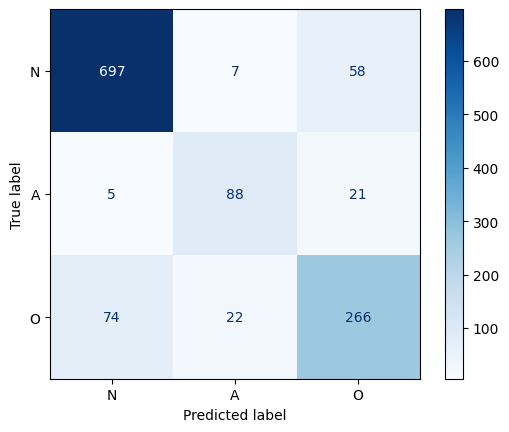

In [8]:
model = DenseNetEcgModule.load_from_checkpoint(checkpoint_callback.last_model_path)
results = trainer.predict(model, dataloaders=dm)
test_loss, test_y_pred, test_y, test_y_hat = aggregate_metrics(results)

# loss
print(f"test_loss: {test_loss}")

# auprc
test_auprc = multiclass_average_precision(test_y_pred, test_y, num_classes=dm.num_classes)
print(f"test_auprc: {test_auprc}")

# auroc
test_auroc = multiclass_auroc(test_y_pred, test_y, num_classes=dm.num_classes)
print(f"test_auroc: {test_auroc}")

# classification report
print(classification_report(test_y, test_y_hat, target_names=dm.test_set.classes))

# confusion matrix
test_cm = confusion_matrix(test_y, test_y_hat)
test_cm_disp = ConfusionMatrixDisplay(
    confusion_matrix=test_cm, display_labels=dm.test_set.classes
)
test_cm_disp.plot(cmap="Blues")
plt.show()

# logger
if wandb_mode != "disabled":
    wandb.log({"last_test_loss": test_loss.item()})
    wandb.log({"last_test_auprc": test_auprc.item()})
    wandb.log({"last_test_auroc": test_auroc.item()})
    wandb.log({"last_test_f1": f1_score(test_y, test_y_hat, average="macro")})
    wandb.log({"last_test_accuracy": accuracy_score(test_y, test_y_hat)})
    wandb.log({"last_test_cm": test_cm_disp.figure_})

### Best model

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 36.87it/s]
test_loss: 0.47033315896987915
test_auprc: 0.8915941119194031
test_auroc: 0.9421892166137695
              precision    recall  f1-score   support

           N       0.90      0.91      0.90       762
           A       0.79      0.82      0.81       114
           O       0.77      0.75      0.76       362

    accuracy                           0.85      1238
   macro avg       0.82      0.83      0.82      1238
weighted avg       0.85      0.85      0.85      1238



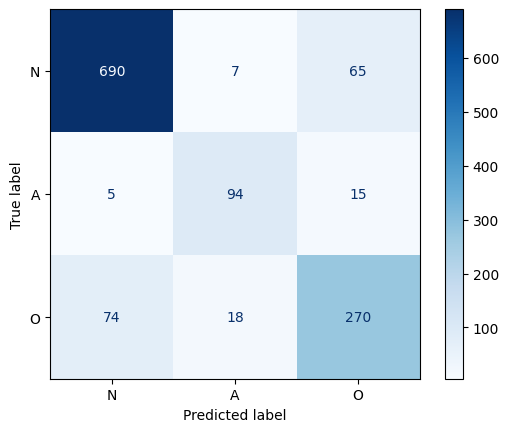

In [9]:
model = DenseNetEcgModule.load_from_checkpoint(checkpoint_callback.best_model_path)
results = trainer.predict(model, dataloaders=dm)
test_loss, test_y_pred, test_y, test_y_hat = aggregate_metrics(results)

# loss
print(f"test_loss: {test_loss}")

# auprc
test_auprc = multiclass_average_precision(test_y_pred, test_y, num_classes=dm.num_classes)
print(f"test_auprc: {test_auprc}")

# auroc
test_auroc = multiclass_auroc(test_y_pred, test_y, num_classes=dm.num_classes)
print(f"test_auroc: {test_auroc}")

# classification report
print(classification_report(test_y, test_y_hat, target_names=dm.test_set.classes))

# confusion matrix
test_cm = confusion_matrix(test_y, test_y_hat)
test_cm_disp = ConfusionMatrixDisplay(
    confusion_matrix=test_cm, display_labels=dm.test_set.classes
)
test_cm_disp.plot(cmap="Blues")
plt.show()

# logger
if wandb_mode != "disabled":
    wandb.log({"best_test_loss": test_loss.item()})
    wandb.log({"best_test_auprc": test_auprc.item()})
    wandb.log({"best_test_auroc": test_auroc.item()})
    wandb.log({"best_test_f1": f1_score(test_y, test_y_hat, average="macro")})
    wandb.log({"best_test_accuracy": accuracy_score(test_y, test_y_hat)})
    wandb.log({"best_test_cm": test_cm_disp.figure_})

In [10]:
wandb.finish()

best_test_accuracy,▁
best_test_auprc,▁
best_test_auroc,▁
best_test_f1,▁
best_test_loss,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███████
last_test_accuracy,▁
last_test_auprc,▁
last_test_auroc,▁
last_test_f1,▁
last_test_loss,▁
